# Challenge: Iterate and evaluate your classifier

It's time to revisit your classifier from the previous assignment. Using the evaluation techniques we've covered here, look at your classifier's performance in more detail. Then go back and iterate by engineering new features, removing poor features, or tuning parameters. Repeat this process until you have five different versions of your classifier. Once you've iterated, answer these questions to compare the performance of each:

1. Do any of your classifiers seem to overfit?
2. Which seem to perform the best? Why?
3. Which features seemed to be most impactful to performance?

Write up your iterations and answers to the above questions in a few pages. Submit a link below and go over it with your mentor to see if they have any other ideas on how you could improve your classifier's performance.

# Classifier evaluation

In order to identify ham and spam , I chose 5 different keyword lists:
1. Classifier provided by thinkful
2. My own choice of words including a regular expression for digits
3. My own choice of words without the regular expression for digits
4. Data driven keywords 
5. A combination of mychoice and the data driven keywords. 

Data driven keywords are generated, by counting the word frequency in spam messages and removing stop words. The 50 most frequent words are chosen as classifiers.

# Testing 
To differentiate spam from ham. 5 different keyword lists are used. The message is scanned for each keyword. The keyword evaluation is than used for the naive bayes classification. The model is trained using 30% of the data. The cross validation is performed on 100 test runs. 


# 1. Overfitting

Assuming that overfitting would be observed when evaluating the varianve of the quality scores from the crossvalidation, I don't think any of the classifier tend to overfit. 

# 2. Observations- Which seem to perform the best? Why?

Using the naive bayes calssification to determine spam the thinkful classifier generate a score of 0.89 and a sensitivity of only 0.04 on average. However, the classifier have a specificity of 0.96 , which is the best result for all classifier groups.
The second classifier group is a keyword list that I generated by eye balling the spam messages. I included all thinkful classifiers, but aiming to improve the score and the sensitivity, I added further words. This improved the score and the specificity a lot, but it reduced specificity.
In the third group of classifiers I removed the regular expression for digits and the effect of the second group were reversed.
Indicating that the strongest classifier of group 2 was the regular expression for digits.
In group 4 I used a data driven approach to identify keywords. Again i obsevred an improvement in the score and sensitivity, but specificity was reduced.
In group 5 I tried to improve the sensitivity of group 3 and 4 by combining the datadriven keys and my choice of words. I cleaned the datadriven keys, by removing a few unspecific words (See the code for details), but the specificity of group 3 could not be implemeted for group 5.

# 3. Most impactful features

The most impactfull features for spam identification was the regex for digits.

In [1]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from nltk.corpus import stopwords
from collections import Counter
import string

In [2]:
def my_cross_val(data, target,folds, test_size):
    scores = []
    df= pd.DataFrame()
    TrueNegatives = []
    FalsePositives = []
    TruePositives = []
    FalseNegatives = []
    Specificity = []
    Sensitivity = []

    bnb = BernoulliNB()
    for f in range(folds):
        data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=test_size)
        scores.append(bnb.fit(data_train, target_train).score(data_test, target_test))
        
        # Prediction of this round
        y_pred=bnb.fit(data_train, target_train).predict(data_test)
        df['y_pred']=y_pred
        df['target']=target_test

        #Make a confuion matrix
        TrueNegatives.append(df[(df.target==False) & (df.y_pred==False)].shape[0])
        FalsePositives.append(len(df[(df.target==False) & (df.y_pred==True)]))
        Specificity.append(len(df[(df.target==False) & (df.y_pred==False)])/len(df[df.target==False]))
        
        TruePositives.append(len(df[(df.target== True) & (df.y_pred == True)]))
        FalseNegatives.append(len(df[(df.target==True) & (df.y_pred==False)]))
        Sensitivity.append(len(df[(df.target==True) & (df.y_pred==True)])/len(df[df.target==True]))
        #Sensitivity.append()

    cf=pd.DataFrame()
    cf['score']= scores
    cf['TrueNegatives'] = TrueNegatives
    cf['FalsePositives'] = FalsePositives
    cf['Specificity']= Specificity
    cf['TruePositives'] = TruePositives
    cf['FalseNegatives']= FalseNegatives
    cf['Sensitivity']= Sensitivity

    return cf

In [3]:
# Grab and process the raw data.
data_path = ("https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
             "master/sms_spam_collection/SMSSpamCollection")

sms_raw = pd.read_csv(data_path, delimiter= '\t', header=None)
sms_raw.columns = ['spam', 'message']
#sms_raw['spam'] = (sms_raw['spam'] == 'spam')
sms_raw.head()

,spam,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
def check_keywords(dat,kw):
    d=pd.DataFrame()
    
    for key in kw:
        d[str(key)] = dat.message.str.contains(' ' + str(key) + ' ',case=False)
    d['allcaps'] = dat.message.str.isupper()
    #print(d['spam'].head())
    d['spam'] = (dat['spam'] == 'spam')
    #print(d['spam'].head())
    allFeatures = d[kw + ['allcaps']]
    return allFeatures

In [5]:
# Enumerate our spammy keywords by hand.
keywords = ['click', 'offer', 'winner', 'buy', 'free', 'cash', 'urgent']
#print('sms_raw:', sms_raw.head())
FirstTry = check_keywords(sms_raw, keywords)
#print(FirstTry)
target1 = (sms_raw['spam'] == 'spam')
Result=my_cross_val(FirstTry,target1,100,0.7)

In [6]:
# data driven keywords function
def extract_keywords(MessageColumn):
    Allword_list = np.array(MessageColumn).tolist()
    #print(Allword_list)
    Allwords= list(str(x[0]) for x in Allword_list)
    #print(Allwords)
    
    SingleWordlistCleaned = []
    for z in Allwords:
        for word in z.split(' '):
            if word not in stopwords.words('english'):
                SingleWordlistCleaned.append(word)
            
    #print(SingleWordlistCleaned)    
    
    SingleWordlistCleanedCount=Counter(SingleWordlistCleaned)
    SWC_df = pd.DataFrame.from_dict(SingleWordlistCleanedCount, orient='index')
    SWC_df = SWC_df.rename(columns={SWC_df.columns[0]: "WordCount"})
    SWC_df.sorted = SWC_df.sort_values(by=['WordCount'], ascending= False)
    
    return SWC_df.sorted

In [7]:
# My keywords by hand
NRKws_rexEx= ['\d+','click', 'offer', 'winner', 'buy','FREE', 'free','CASH', 'cash', 'urgent','text','txt','TXT','reply','$','£','call']

In [8]:
dNR = check_keywords(sms_raw, NRKws_rexEx)
#sms_raw_data = pd.concat(sms_raw,data, axis=0)
target2 = (sms_raw['spam'] == 'spam')
Result2= my_cross_val(dNR,target2,100,0.7)

In [9]:
# My keywords by hand

NRKws= ['click', 'offer', 'winner', 'buy','FREE', 'free','CASH', 'cash', 'urgent','text','txt','TXT','reply','$','£','call']

In [10]:
dNR = check_keywords(sms_raw, NRKws)
#sms_raw_data = pd.concat(sms_raw,data, axis=0)
target3 = (sms_raw['spam'] == 'spam')
Result3= my_cross_val(dNR,target2,100,0.7)

In [11]:
#Select the message column and select keywords, by counting the most frequent words - stop.words
spam= pd.DataFrame(sms_raw[sms_raw.spam=='spam'].message)
datakeys = extract_keywords(spam)
#print(datakeys)
datakeys['Words']= datakeys.index

datadrivenkeys = datakeys.Words[0:50].tolist() #Select the top 50

#Run Model
dDat = check_keywords(sms_raw, datadrivenkeys)
#sms_raw_data = pd.concat(sms_raw,data, axis=0)
target4 = (sms_raw['spam'] == 'spam')
Result4= my_cross_val(dDat,target3,100,0.7)

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


In [43]:
print(datadrivenkeys)

['call', '2', 'Call', 'ur', '&', '4', 'FREE', 'mobile', 'You', 'To', 'claim', 'Your', 'U', 'text', 'txt', 'Txt', 'reply', 'contact', 'free', '-', 'now!', 'u', 'send', 'get', 'Nokia', 'STOP', 'per', 'prize', 'service', 'new', 'Reply', 'cash', 'Text', 'This', 'stop', 'awarded', 'We', 'Free', 'Please', '£1000', 'draw', 'URGENT!', 'every', 'Get', '', 'PO', 'shows', 'week', 'Just', '1']


In [44]:
# Combi of handchoice and datadriven solution
# Clean datadriven key by hand
#removed 2,4
#Removed You, to, '-', send, get
datadrivenkeyscleaned=['call', 'Call', 'ur', '&', 'FREE', 'mobile', 'claim', 'Your', 'U', 'text', 'txt', 'Txt', 'reply', 'contact', 'free', 'now!', 'u', 'Nokia', 'STOP', 'per', 'prize', 'service', 'new', 'Reply', 'cash', 'Text', 'This', 'stop', 'awarded', 'We', 'Free', 'Please', '£1000', 'draw', 'URGENT!', 'every', 'Get', 'PO', 'shows', 'week', 'Just']

Bothlists = list(set(NRKws + datadrivenkeyscleaned)) # set() removes dupliccates
#print(Bothlists)

#Run Model
dDat = check_keywords(sms_raw, datadrivenkeys)
#sms_raw_data = pd.concat(sms_raw,data, axis=0)
target5 = (sms_raw['spam'] == 'spam')
Result5= my_cross_val(dDat,target3,100,0.7)

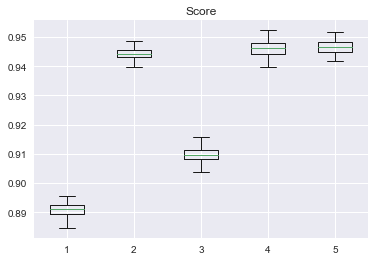

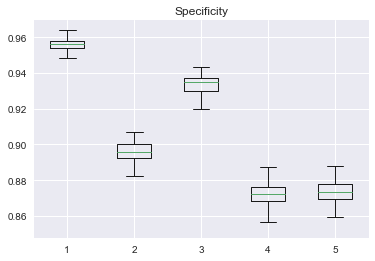

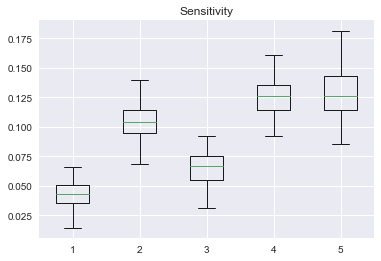

In [45]:
# Plot individual quality data
# Plot the Scores
scores = [Result.score,Result2.score, Result3.score, Result4.score, Result5.score]
plt.boxplot(scores)
plt.title("Score")
plt.show()

# Plot specificity
Spec = [Result.Specificity,Result2.Specificity, Result3.Specificity, Result4.Specificity,Result5.Specificity]
plt.boxplot(Spec)
plt.title("Specificity")
plt.show()

# Plot specificity
Sen = [Result.Sensitivity,Result2.Sensitivity, Result3.Sensitivity, Result4.Sensitivity,Result5.Sensitivity]
plt.boxplot(Sen)
plt.title("Sensitivity")
plt.show()

  ClassifierGroup  1-Specificity  Sensitivity
0        thinkful       0.044263     0.042885
1       NR_digits       0.103767     0.104467
2     NR_nodigits       0.066592     0.065357
3  Datadrivenkeys       0.128098     0.125885
4           Combi       0.127315     0.124268


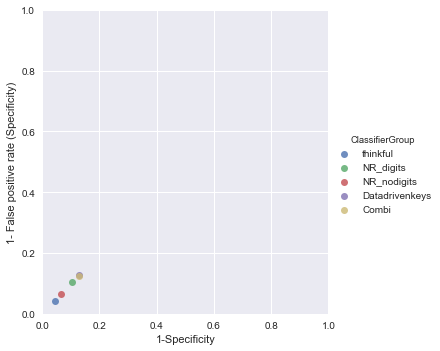

In [42]:
# Prepare data for merge to plot
#SPecificity data
results = pd.DataFrame()
results['ClassifierGroup']= ['thinkful', 'NR_digits', 'NR_nodigits','Datadrivenkeys','Combi']
results['1-Specificity']= [1-Result['Specificity'].mean(),
                   1-Result2['Specificity'].mean(),
                   1-Result3['Specificity'].mean(),
                   1-Result4['Specificity'].mean(),
                   1-Result5['Specificity'].mean()]
results['Sensitivity']= [Result['Sensitivity'].mean(),
                   Result2['Sensitivity'].mean(),
                   Result3['Sensitivity'].mean(),
                   Result4['Sensitivity'].mean(),
                   Result5['Sensitivity'].mean()]

print(results.head())

#Plot
import seaborn as sns
sns.set(color_codes=True)
sns.lmplot(x="1-Specificity", y="Sensitivity",hue="ClassifierGroup", data= results,fit_reg=False)
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.ylabel('True positive rate (Sensitivity)')
plt.ylabel('1- False positive rate (Specificity)')
plt.show()